<figure style="text-align:center;">
  <img src="rover.png" alt="Mars Rover" style="max-width:700px; width:100%; height:auto;"/>
  <figcaption><strong>Figure:</strong> A rover navigating a linear Martian landscape.</figcaption>
</figure>

### Analysis of TD(0), FVMC, SARSA, Q-Learning, and Double Q-Learning Methods

The **`Mars_Rover_control.ipynb`** notebook provides an in-depth implementation of multiple reinforcement learning methods: **TD(0)**, **First-Visit Monte Carlo (FVMC)**, **SARSA**, **Q-Learning**, and **Double Q-Learning**. These methods are analyzed and compared on a simulated Mars Rover environment to showcase their strengths, trade-offs, and behavior over time during learning.

---

### Key Features:

1. **Development and Usage of Policy-Based Value Iterations**
   The notebook employs dynamic programming methods (e.g., value iteration) as a benchmark for optimal state and policy evaluations.

2. **Model-Free RL Methods**
   Introduces multiple temporal difference (TD) based approaches, highlighting:
   - **First-Visit Monte Carlo (FVMC):** Focuses on estimating state values by averaging returns during 'first-visit' exploration.
   - **SARSA:** Utilizes pairs of State-Action-Reward-State-Action (SARSA) for on-policy learning.
   - **Q-Learning:** Demonstrates an off-policy temporal difference method.
   - **Double Q-Learning:** Addresses over-estimation bias in Q-values by splitting the value update process into two.

3. **Visualization Features**
   The notebook provides vivid visual comparisons through:
   - Learning curves showing root-mean-squared error (RMSE) decay across episodes.
   - Estimated vs. true value function plots for optimal policy derivation.
   - Convergence dynamics across large grids of step-size **(α)** variations.
   - Success rate, regret, and average return metrics across time and learning methods.

4. **Hyperparameter Analysis**
   Analysis of decaying step-size schedules, exploration probabilities (ε-greedy), and visualization of the practical effects of hyperparameter selection on convergence.

5. **Exploration of Optimal Policy**
   The notebook evaluates and visualizes policies that guide the rover to its goal state with optimal efficiency while avoiding penalties.

---

### Additional Material:

Full implementation of the Mars Rover environment and supporting materials are available in the repository:
[Mars Rover GitHub Repository](https://github.com/MathPhysSim/MARS_ROVER)

---

### Authors

**Simon Hirlaender, Dipl.-Ing. Dr., BSc** – Head, SARL Team, IDA Lab, University of Salzburg
Contact: **simon.hirlaender@plus.ac.at**

**Olga Mironova, BA MSc** – Researcher, SARL Team, IDA Lab, University of Salzburg
Contact: **olga.mironova@plus.ac.at**


---

### Institutional Support

• **IDA Lab** – Intelligent Data Analytics Lab, University of Salzburg
  Website: <https://idalab.at>

• **SARL (Smart Analytics & Reinforcement Learning)** – Research team within IDA Lab
  Website: <https://sarl-plus.github.io>


---

In [28]:
import warnings ; warnings.filterwarnings('ignore')
import itertools
import numpy as np
from tabulate import tabulate
from tqdm.auto import tqdm
from itertools import cycle, count
from Mars_Rover_env import MarsRoverEnv
import random
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

In [46]:
from itertools import cycle

DEFAULT_LINECYCLER = cycle(["-", "--", ":", "-."])
DEFAULT_COLORCYCLER = cycle(["lime", "blue", "dodgerblue", "red", "orange", "orange"])

In [47]:
SEEDS = (12, 34, 56, 78, 90)

env = MarsRoverEnv(p_stay=1/3,p_backward=1/6)
#
# params = {'figure.figsize': (15, 8), 'font.size': 24, 'legend.fontsize': 20, 'axes.titlesize': 28,
#     'axes.labelsize': 24, 'xtick.labelsize': 20, 'ytick.labelsize': 20}
# pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

In [48]:
def value_iteration(P, gamma=1.0, theta=1e-10):
    V = np.zeros(len(P), dtype=np.float64)
    while True:
        Q = np.zeros((len(P), len(P[0])), dtype=np.float64)
        for s in range(len(P)):
            for a in range(len(P[s])):
                for prob, next_state, reward, done in P[s][a]:
                    Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))
        if np.max(np.abs(V - np.max(Q, axis=1))) < theta:
            break
        V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi

def print_policy(pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4, title='Policy:'):
    print(title)
    arrs = {k:v for k,v in enumerate(action_symbols)}
    for s in range(len(P)):
        a = pi(s)
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), arrs[a].rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [49]:
def print_state_value_function(V, P, n_cols=4, prec=3, title='State-value function:'):
    print(title)
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), '{}'.format(np.round(v, prec)).rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

def print_action_value_function(Q, optimal_Q=None, action_symbols=('<', '>'), prec=3, title='Action-value function:'):
    vf_types=('',) if optimal_Q is None else ('', '*', 'err')
    headers = ['s',] + [' '.join(i) for i in list(itertools.product(vf_types, action_symbols))]
    print(title)
    states = np.arange(len(Q))[..., np.newaxis]
    arr = np.hstack((states, np.round(Q, prec)))
    if not (optimal_Q is None):
        arr = np.hstack((arr, np.round(optimal_Q, prec), np.round(optimal_Q-Q, prec)))
    print(tabulate(arr, headers, tablefmt="fancy_grid"))


In [50]:
def get_policy_metrics(env, gamma, pi, goal_state, optimal_Q, n_episodes=100, max_steps=200):
    random.seed(123);
    np.random.seed(123);
    env.seed(123)
    reached_goal, episode_reward, episode_regret = [], [], []
    for _ in range(n_episodes):
        state, done, steps = env.reset(), False, 0
        episode_reward.append(0.0)
        episode_regret.append(0.0)
        while not done and steps < max_steps:
            action = pi(state)
            regret = np.max(optimal_Q[state]) - optimal_Q[state][action]
            episode_regret[-1] += regret

            state, reward, done, _ = env.step(action)
            episode_reward[-1] += (gamma ** steps * reward)

            steps += 1

        reached_goal.append(state == goal_state)
    results = np.array((np.sum(reached_goal) / len(reached_goal) * 100,
                        np.mean(episode_reward),
                        np.mean(episode_regret)))
    return results

In [51]:
def get_metrics_from_tracks(env, gamma, goal_state, optimal_Q, pi_track, coverage=0.1):
    total_samples = len(pi_track)
    n_samples = int(total_samples * coverage)
    samples_e = np.linspace(0, total_samples, n_samples, endpoint=False, dtype=int)
    metrics = []
    for e, pi in enumerate(tqdm(pi_track)):
        if e in samples_e:
            metrics.append(get_policy_metrics(
                env,
                gamma=gamma,
                pi=lambda s: pi[s],
                goal_state=goal_state,
                optimal_Q=optimal_Q))
        else:
            metrics.append(metrics[-1])
    metrics = np.array(metrics)
    success_rate_ma, mean_return_ma, mean_regret_ma = np.apply_along_axis(moving_average, axis=0, arr=metrics).T
    return success_rate_ma, mean_return_ma, mean_regret_ma


def rmse(x, y, dp=4):
    return np.round(np.sqrt(np.mean((x - y) ** 2)), dp)


def moving_average(a, n=100):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


In [61]:
def plot_value_function(title, V_track, V_true=None, log=False, limit_value=0.05, limit_items=5):
    np.random.seed(123)
    per_col = 25
        # Use the global DEFAULT_* variables
    linecycler = DEFAULT_LINECYCLER
    colorcycler = DEFAULT_COLORCYCLER

    legends = []

    valid_values = np.argwhere(V_track[-1] > limit_value).squeeze()
    items_idxs = np.random.choice(valid_values,
                                  min(len(valid_values), limit_items),
                                  replace=False)
    # draw the true values first
    if V_true is not None:
        for i, state in enumerate(V_track.T):
            if i not in items_idxs:
                continue
            if state[-1] < limit_value:
                continue

            label = 'v*({})'.format(i)
            plt.axhline(y=V_true[i], color='k', linestyle='-', linewidth=1)
            plt.text(int(len(V_track) * 1.02), V_true[i] + .01, label)

    # then the estimates
    for i, state in enumerate(V_track.T):
        if i not in items_idxs:
            continue
        if state[-1] < limit_value:
            continue
        line_type = next(linecycler)
        color = next(colorcycler)
        label = 'V({})'.format(i)
        p, = plt.plot(state, line_type, label=label, linewidth=1, color=color)
        legends.append(p)
        legends.append(p)

    legends.reverse()

    ls = []
    for loc, idx in enumerate(range(0, len(legends), per_col)):
        subset = legends[idx:idx + per_col]
        l = plt.legend(subset, [p.get_label() for p in subset],
                       loc='center right', bbox_to_anchor=(1.25, 0.5))
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]
    if log: plt.xscale('log')
    plt.title(title)
    plt.ylabel('State-value function')
    plt.xlabel('Episodes (log scale)' if log else 'Episodes')
    plt.show()

In [62]:
def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

init_state = env.reset()
goal_state = 6
gamma = 0.99
n_episodes = 3000
P = env.P
n_cols, svf_prec, err_prec, avf_prec=9, 4, 2, 3
action_symbols=('<', '>')
limit_items, limit_value = 5, 0.0
cu_limit_items, cu_limit_value, cu_episodes = 10, 0.0, 100

Looking at alpha and epsilon


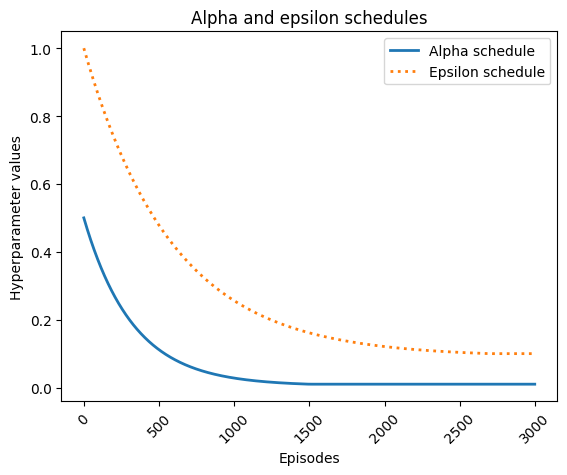

In [63]:
'''Alpha and Epsilon during training'''
print('Looking at alpha and epsilon')
plt.plot(decay_schedule(0.5, 0.01, 0.5, n_episodes), '-', linewidth=2, label='Alpha schedule')
plt.plot(decay_schedule(1.0, 0.1, 0.9, n_episodes), ':', linewidth=2, label='Epsilon schedule')
plt.legend(loc=1, ncol=1)
plt.title('Alpha and epsilon schedules')
plt.xlabel('Episodes')
plt.ylabel('Hyperparameter values')
plt.xticks(rotation=45)
plt.show()

In [64]:
'''Optimal value function policy'''
print('Overview of states, actions and policy')
optimal_Q, optimal_V, optimal_pi = value_iteration(P, gamma=gamma)
print_state_value_function(optimal_V, P, n_cols=n_cols, prec=svf_prec, title='Optimal state-value function:')
print()
print_action_value_function(optimal_Q, None, action_symbols=action_symbols, prec=avf_prec, title='Optimal action-value function:')
print()
print_policy(optimal_pi, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_op, mean_return_op, mean_regret_op = get_policy_metrics(env, gamma=gamma, pi=optimal_pi, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(success_rate_op, mean_return_op, mean_regret_op))

Overview of states, actions and policy
Optimal state-value function:
|           | 01 6.3106 | 02  8.205 | 03 9.0022 | 04 9.4498 | 05 9.7899 |           
Optimal action-value function:
╒═════╤═══════╤═══════╕
│   s │     < │     > │
╞═════╪═══════╪═══════╡
│   0 │ 0     │ 0     │
├─────┼───────┼───────┤
│   1 │ 3.936 │ 6.311 │
├─────┼───────┼───────┤
│   2 │ 7.317 │ 8.205 │
├─────┼───────┼───────┤
│   3 │ 8.591 │ 9.002 │
├─────┼───────┼───────┤
│   4 │ 9.19  │ 9.45  │
├─────┼───────┼───────┤
│   5 │ 9.575 │ 9.79  │
├─────┼───────┼───────┤
│   6 │ 0     │ 0     │
╘═════╧═══════╧═══════╛

Policy:
|           | 01      > | 02      > | 03      > | 04      > | 05      > |           Reaches goal 85.00%. Obtains an average return of 7.9031. Regret of 0.0000


In [65]:
'''First Visit Monte Carlo'''
print('Do first visit monte carlo:')
def generate_trajectory(select_action, Q, epsilon, env, max_steps=200):
    done, trajectory = False, []
    while not done:
        state = env.reset()
        for t in count():
            action = select_action(state, Q, epsilon)
            next_state, reward, done, _ = env.step(action)
            experience = (state, action, reward, next_state, done)
            trajectory.append(experience)
            if done:
                break
            if t >= max_steps - 1:
                trajectory = []
                break
            state = next_state
    return np.array(trajectory, dtype=object)


def mc_control(env,
               gamma=1.0,
               init_alpha=0.5,
               min_alpha=0.01,
               alpha_decay_ratio=0.5,
               init_epsilon=1.0,
               min_epsilon=0.1,
               epsilon_decay_ratio=0.9,
               n_episodes=3000,
               max_steps=200,
               first_visit=True):
    nS, nA = env.observation_space.n, env.action_space.n
    discounts = np.logspace(0,
                            max_steps,
                            num=max_steps,
                            base=gamma,
                            endpoint=False)
    alphas = decay_schedule(init_alpha,
                            min_alpha,
                            alpha_decay_ratio,
                            n_episodes)
    epsilons = decay_schedule(init_epsilon,
                              min_epsilon,
                              epsilon_decay_ratio,
                              n_episodes)
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))

    for e in tqdm(range(n_episodes), leave=False):

        trajectory = generate_trajectory(select_action,
                                         Q,
                                         epsilons[e],
                                         env,
                                         max_steps)
        visited = np.zeros((nS, nA), dtype=bool)
        for t, (state, action, reward, _, _) in enumerate(trajectory):
            if visited[state][action] and first_visit:
                continue
            visited[state][action] = True

            n_steps = len(trajectory[t:])
            G = np.sum(discounts[:n_steps] * trajectory[t:, 2])
            Q[state][action] = Q[state][action] + alphas[e] * (G - Q[state][action])

        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: {s: a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

Q_mcs, V_mcs, Q_track_mcs = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_mc, V_mc, pi_mc, Q_track_mc, pi_track_mc = mc_control(env, gamma=gamma, n_episodes=n_episodes)
    Q_mcs.append(Q_mc) ; V_mcs.append(V_mc) ; Q_track_mcs.append(Q_track_mc)
Q_mc, V_mc, Q_track_mc = np.mean(Q_mcs, axis=0), np.mean(V_mcs, axis=0), np.mean(Q_track_mcs, axis=0)
del Q_mcs ; del V_mcs ; del Q_track_mcs

print_state_value_function(V_mc, P, n_cols=n_cols,
                           prec=svf_prec, title='State-value function found by FVMC:')
print_state_value_function(optimal_V, P, n_cols=n_cols,
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_mc - optimal_V, P, n_cols=n_cols,
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_mc, optimal_V)))
print()
print_action_value_function(Q_mc, optimal_Q, action_symbols=action_symbols, prec=avf_prec,
                            title='FVMC action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_mc, optimal_Q)))
print()
print_policy(pi_mc, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_mc, mean_return_mc, mean_regret_mc = get_policy_metrics(
    env, gamma=gamma, pi=pi_mc, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_mc, mean_return_mc, mean_regret_mc))

Do first visit monte carlo:


All seeds: 100%|██████████| 5/5 [00:01<00:00,  4.41it/s]A

State-value function found by FVMC:
|           | 01 5.8048 | 02 7.8583 | 03 8.8266 | 04 9.3886 | 05 9.7905 |           Optimal state-value function:
|           | 01 6.3106 | 02  8.205 | 03 9.0022 | 04 9.4498 | 05 9.7899 |           State-value function errors:
|           | 01  -0.51 | 02  -0.35 | 03  -0.18 | 04  -0.06 | 05    0.0 |           State-value function RMSE: 0.2422

FVMC action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╕
│   s │     < │     > │   * < │   * > │   err < │   err > │
╞═════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╡
│   0 │ 0     │ 0     │ 0     │ 0     │   0     │   0     │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   1 │ 3.423 │ 5.805 │ 3.936 │ 6.311 │   0.513 │   0.506 │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   2 │ 6.762 │ 7.858 │ 7.317 │ 8.205 │   0.554 │   0.347 │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   3 │ 8.304 │ 8.827 │ 8.591 │ 9.002 │   0.287 │ 

In [66]:
'''SARSA'''
print('Do SARSA')
def sarsa(env,
          gamma=1.0,
          init_alpha=0.5,
          min_alpha=0.01,
          alpha_decay_ratio=0.5,
          init_epsilon=1.0,
          min_epsilon=0.1,
          epsilon_decay_ratio=0.9,
          n_episodes=3000):
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    alphas = decay_schedule(init_alpha,
                            min_alpha,
                            alpha_decay_ratio,
                            n_episodes)
    epsilons = decay_schedule(init_epsilon,
                              min_epsilon,
                              epsilon_decay_ratio,
                              n_episodes)

    for e in tqdm(range(n_episodes), leave=False):
        state, done = env.reset(), False
        action = select_action(state, Q, epsilons[e])
        while not done:
            next_state, reward, done, _ = env.step(action)
            next_action = select_action(next_state, Q, epsilons[e])
            td_target = reward + gamma * Q[next_state][next_action] * (not done)
            td_error = td_target - Q[state][action]
            Q[state][action] = Q[state][action] + alphas[e] * td_error
            state, action = next_state, next_action
        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: {s: a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

Q_sarsas, V_sarsas, Q_track_sarsas = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_sarsa, V_sarsa, pi_sarsa, Q_track_sarsa, pi_track_sarsa = sarsa(env, gamma=gamma, n_episodes=n_episodes)
    Q_sarsas.append(Q_sarsa) ; V_sarsas.append(V_sarsa) ; Q_track_sarsas.append(Q_track_sarsa)
Q_sarsa = np.mean(Q_sarsas, axis=0)
V_sarsa = np.mean(V_sarsas, axis=0)
Q_track_sarsa = np.mean(Q_track_sarsas, axis=0)
del Q_sarsas ; del V_sarsas ; del Q_track_sarsas

print_state_value_function(V_sarsa, P, n_cols=n_cols,
                           prec=svf_prec, title='State-value function found by Sarsa:')
print_state_value_function(optimal_V, P, n_cols=n_cols,
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_sarsa - optimal_V, P, n_cols=n_cols,
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_sarsa, optimal_V)))
print()
print_action_value_function(Q_sarsa,
                            optimal_Q,
                            action_symbols=action_symbols,
                            prec=avf_prec,
                            title='Sarsa action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_sarsa, optimal_Q)))
print()
print_policy(pi_sarsa, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_sarsa, mean_return_sarsa, mean_regret_sarsa = get_policy_metrics(
    env, gamma=gamma, pi=pi_sarsa, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_sarsa, mean_return_sarsa, mean_regret_sarsa))

Do SARSA


All seeds: 100%|██████████| 5/5 [00:00<00:00,  6.06it/s]A

State-value function found by Sarsa:
|           | 01 6.0148 | 02 7.8516 | 03 8.8035 | 04 9.3429 | 05 9.7531 |           Optimal state-value function:
|           | 01 6.3106 | 02  8.205 | 03 9.0022 | 04 9.4498 | 05 9.7899 |           State-value function errors:
|           | 01   -0.3 | 02  -0.35 | 03   -0.2 | 04  -0.11 | 05  -0.04 |           State-value function RMSE: 0.1944

Sarsa action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╕
│   s │     < │     > │   * < │   * > │   err < │   err > │
╞═════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╡
│   0 │ 0     │ 0     │ 0     │ 0     │   0     │   0     │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   1 │ 3.34  │ 6.015 │ 3.936 │ 6.311 │   0.596 │   0.296 │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   2 │ 6.789 │ 7.852 │ 7.317 │ 8.205 │   0.528 │   0.353 │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   3 │ 8.179 │ 8.804 │ 8.591 │ 9.002 │   0.413 

In [67]:
'''Q-Learning'''
print('Do Q-Learning')
def q_learning(env,
               gamma=1.0,
               init_alpha=0.5,
               min_alpha=0.01,
               alpha_decay_ratio=0.5,
               init_epsilon=1.0,
               min_epsilon=0.1,
               epsilon_decay_ratio=0.9,
               n_episodes=3000):
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    alphas = decay_schedule(init_alpha,
                           min_alpha,
                           alpha_decay_ratio,
                           n_episodes)
    epsilons = decay_schedule(init_epsilon,
                              min_epsilon,
                              epsilon_decay_ratio,
                              n_episodes)
    for e in tqdm(range(n_episodes), leave=False):
        state, done = env.reset(), False
        while not done:
            action = select_action(state, Q, epsilons[e])
            next_state, reward, done, _ = env.step(action)
            td_target = reward + gamma * Q[next_state].max() * (not done)
            td_error = td_target - Q[state][action]
            Q[state][action] = Q[state][action] + alphas[e] * td_error
            state = next_state

        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

Q_qls, V_qls, Q_track_qls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_ql, V_ql, pi_ql, Q_track_ql, pi_track_ql = q_learning(env, gamma=gamma, n_episodes=n_episodes)
    Q_qls.append(Q_ql) ; V_qls.append(V_ql) ; Q_track_qls.append(Q_track_ql)
Q_ql = np.mean(Q_qls, axis=0)
V_ql = np.mean(V_qls, axis=0)
Q_track_ql = np.mean(Q_track_qls, axis=0)
del Q_qls ; del V_qls ; del Q_track_qls

print_state_value_function(V_ql, P, n_cols=n_cols,
                           prec=svf_prec, title='State-value function found by Q-learning:')
print_state_value_function(optimal_V, P, n_cols=n_cols,
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_ql - optimal_V, P, n_cols=n_cols,
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_ql, optimal_V)))
print()
print_action_value_function(Q_ql,
                            optimal_Q,
                            action_symbols=action_symbols,
                            prec=avf_prec,
                            title='Q-learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_ql, optimal_Q)))
print()
print_policy(pi_ql, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_ql, mean_return_ql, mean_regret_ql = get_policy_metrics(
    env, gamma=gamma, pi=pi_ql, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_ql, mean_return_ql, mean_regret_ql))

Do Q-Learning


All seeds: 100%|██████████| 5/5 [00:01<00:00,  4.50it/s]A

State-value function found by Q-learning:
|           | 01 6.2703 | 02 8.2096 | 03 8.9999 | 04 9.4548 | 05 9.8067 |           Optimal state-value function:
|           | 01 6.3106 | 02  8.205 | 03 9.0022 | 04 9.4498 | 05 9.7899 |           State-value function errors:
|           | 01  -0.04 | 02    0.0 | 03   -0.0 | 04    0.0 | 05   0.02 |           State-value function RMSE: 0.0167

Q-learning action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╕
│   s │     < │     > │   * < │   * > │   err < │   err > │
╞═════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╡
│   0 │ 0     │ 0     │ 0     │ 0     │   0     │   0     │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   1 │ 3.947 │ 6.27  │ 3.936 │ 6.311 │  -0.011 │   0.04  │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   2 │ 7.201 │ 8.21  │ 7.317 │ 8.205 │   0.115 │  -0.005 │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   3 │ 8.587 │ 9     │ 8.591 │ 9.002 

In [68]:
''''Double Q-Learning'''
print('Do double Q-Learning')
def double_q_learning(env,
                      gamma=1.0,
                      init_alpha=0.5,
                      min_alpha=0.01,
                      alpha_decay_ratio=0.5,
                      init_epsilon=1.0,
                      min_epsilon=0.1,
                      epsilon_decay_ratio=0.9,
                      n_episodes=3000):
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q1 = np.zeros((nS, nA), dtype=np.float64)
    Q2 = np.zeros((nS, nA), dtype=np.float64)
    Q_track1 = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    Q_track2 = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    alphas = decay_schedule(init_alpha,
                           min_alpha,
                           alpha_decay_ratio,
                           n_episodes)
    epsilons = decay_schedule(init_epsilon,
                              min_epsilon,
                              epsilon_decay_ratio,
                              n_episodes)
    for e in tqdm(range(n_episodes), leave=False):
        state, done = env.reset(), False
        while not done:
            action = select_action(state, (Q1 + Q2)/2, epsilons[e])
            next_state, reward, done, _ = env.step(action)

            if np.random.randint(2):
                argmax_Q1 = np.argmax(Q1[next_state])
                td_target = reward + gamma * Q2[next_state][argmax_Q1] * (not done)
                td_error = td_target - Q1[state][action]
                Q1[state][action] = Q1[state][action] + alphas[e] * td_error
            else:
                argmax_Q2 = np.argmax(Q2[next_state])
                td_target = reward + gamma * Q1[next_state][argmax_Q2] * (not done)
                td_error = td_target - Q2[state][action]
                Q2[state][action] = Q2[state][action] + alphas[e] * td_error
            state = next_state

        Q_track1[e] = Q1
        Q_track2[e] = Q2
        pi_track.append(np.argmax((Q1 + Q2)/2, axis=1))

    Q = (Q1 + Q2)/2.
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, (Q_track1 + Q_track2)/2., pi_track

Q_dqls, V_dqls, Q_track_dqls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_dql, V_dql, pi_dql, Q_track_dql, pi_track_dql = double_q_learning(env, gamma=gamma, n_episodes=n_episodes)
    Q_dqls.append(Q_dql) ; V_dqls.append(V_dql) ; Q_track_dqls.append(Q_track_dql)
Q_dql, V_dql, Q_track_dql = np.mean(Q_dqls, axis=0), np.mean(V_dqls, axis=0), np.mean(Q_track_dqls, axis=0)
del Q_dqls ; del V_dqls ; del Q_track_dqls

print_state_value_function(V_dql, P, n_cols=n_cols,
                           prec=svf_prec, title='State-value function found by Double Q-Learning:')
print_state_value_function(optimal_V, P, n_cols=n_cols,
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_dql - optimal_V, P, n_cols=n_cols,
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_dql, optimal_V)))
print()
print_action_value_function(Q_dql,
                            optimal_Q,
                            action_symbols=action_symbols,
                            prec=avf_prec,
                            title='Double Q-Learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_dql, optimal_Q)))
print()
print_policy(pi_dql, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_dql, mean_return_dql, mean_regret_dql = get_policy_metrics(
    env, gamma=gamma, pi=pi_dql, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_dql, mean_return_dql, mean_regret_dql))

Do double Q-Learning


All seeds: 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]A

State-value function found by Double Q-Learning:
|           | 01 6.2397 | 02 8.2398 | 03  8.998 | 04 9.4516 | 05 9.7861 |           Optimal state-value function:
|           | 01 6.3106 | 02  8.205 | 03 9.0022 | 04 9.4498 | 05 9.7899 |           State-value function errors:
|           | 01  -0.07 | 02   0.03 | 03   -0.0 | 04    0.0 | 05   -0.0 |           State-value function RMSE: 0.0299

Double Q-Learning action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╕
│   s │     < │     > │   * < │   * > │   err < │   err > │
╞═════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╡
│   0 │ 0     │ 0     │ 0     │ 0     │   0     │   0     │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   1 │ 3.872 │ 6.24  │ 3.936 │ 6.311 │   0.064 │   0.071 │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   2 │ 7.288 │ 8.24  │ 7.317 │ 8.205 │   0.029 │  -0.035 │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   3 │ 8.607 │ 8.998 │ 

Doing the comparison plots


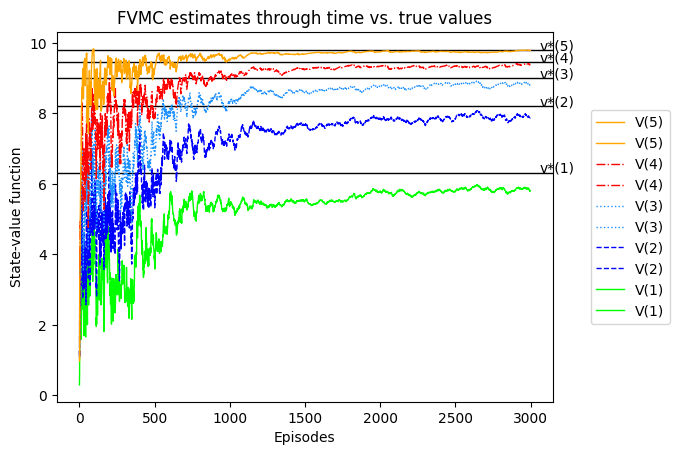

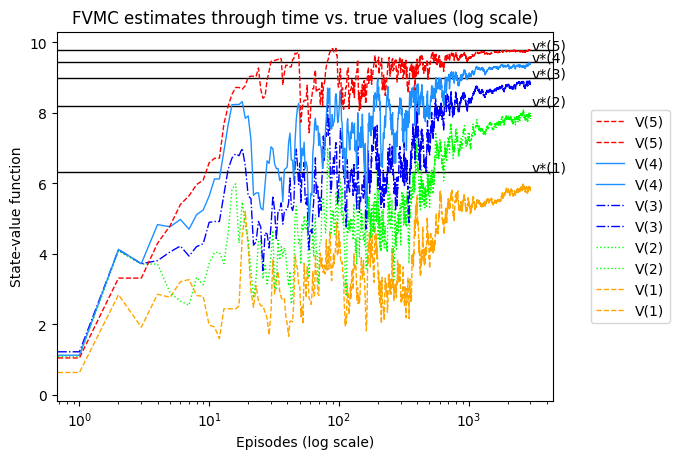

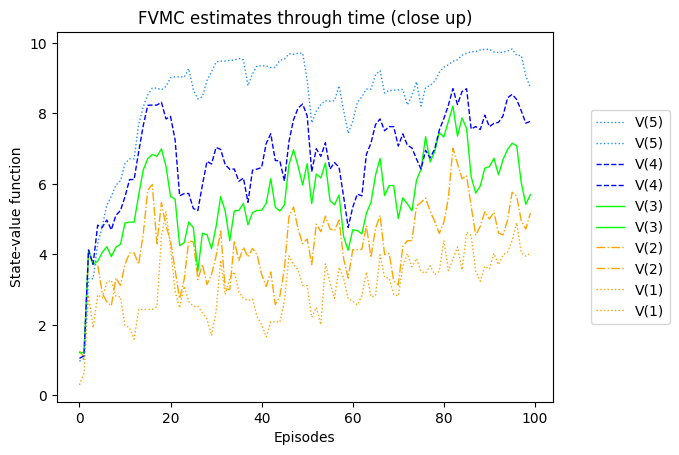

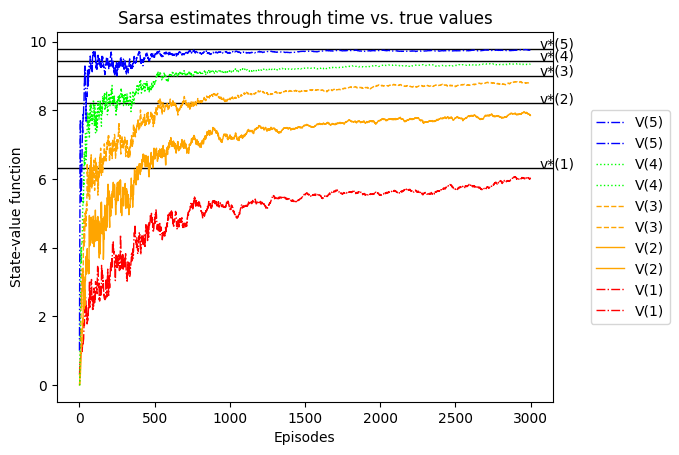

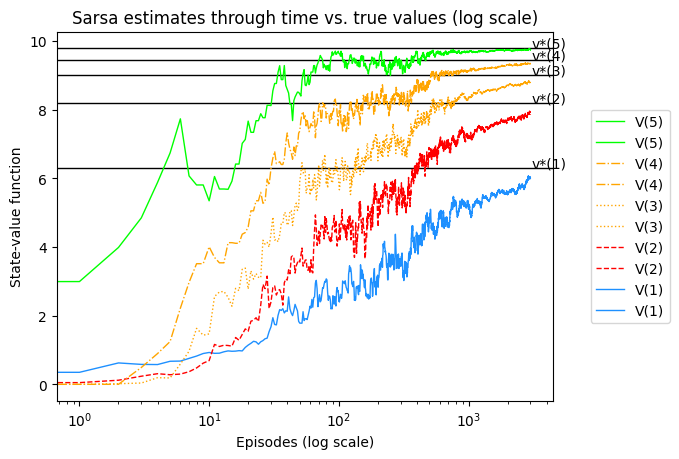

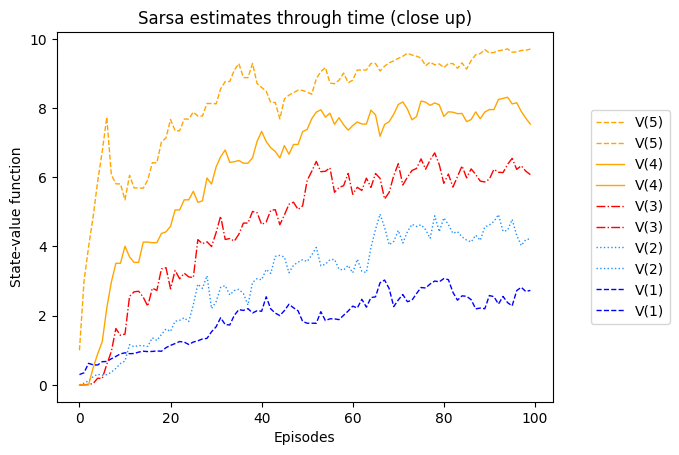

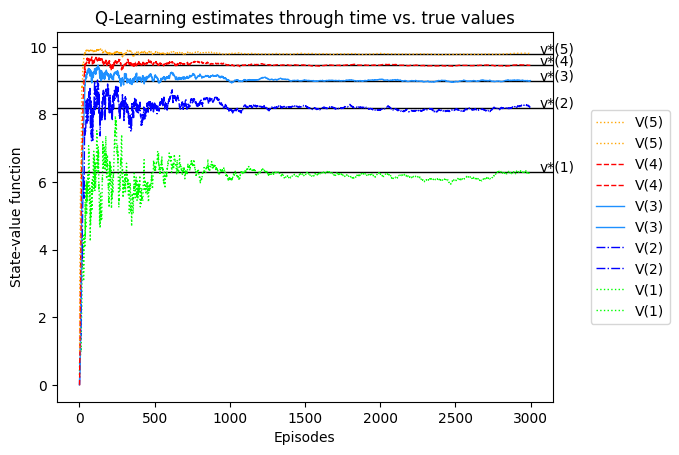

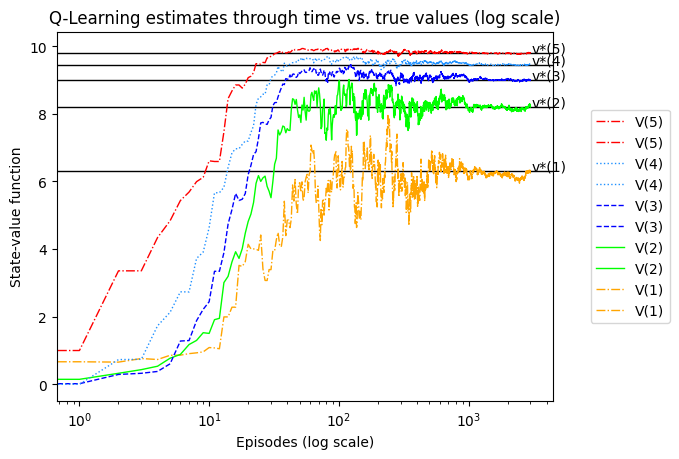

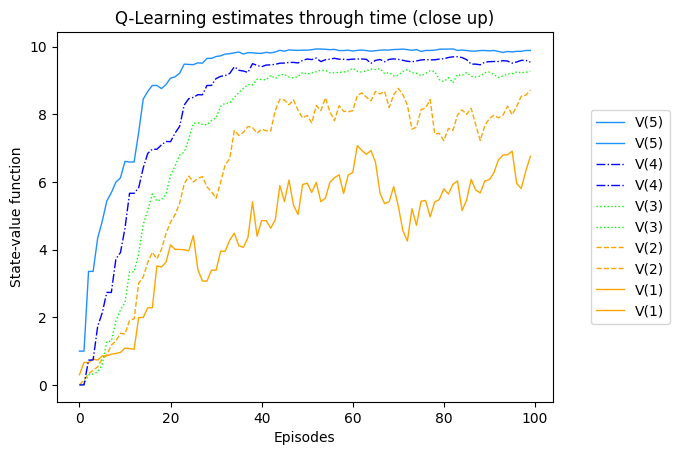

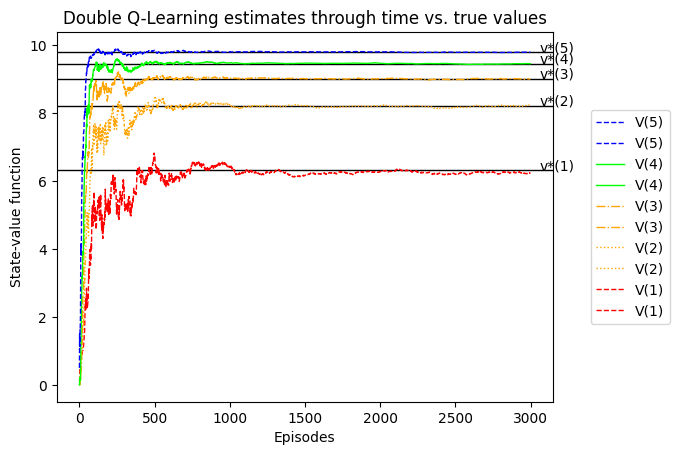

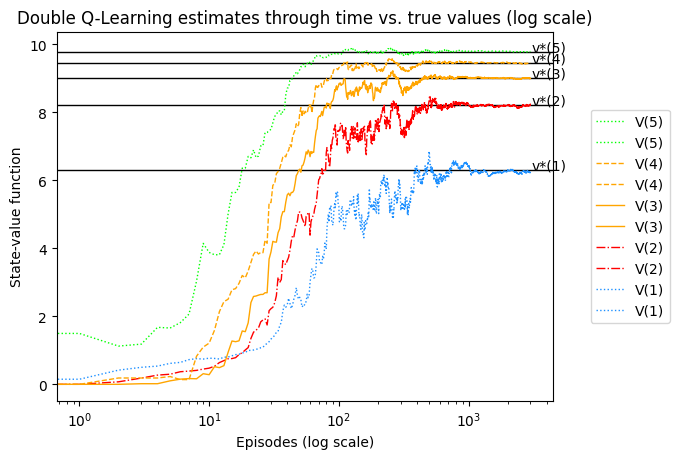

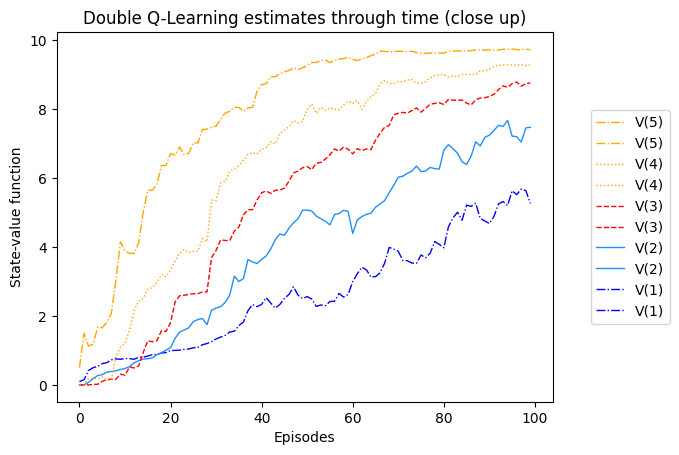

In [69]:
'''Comparing max(Q) for every episode
starting with first visit monte carlo'''
print('Doing the comparison plots')
plot_value_function('FVMC estimates through time vs. true values', np.max(Q_track_mc, axis=2),
    optimal_V, limit_items=limit_items,limit_value=limit_value, log=False)

plot_value_function(
    'FVMC estimates through time vs. true values (log scale)',
    np.max(Q_track_mc, axis=2),
    optimal_V,
    limit_items=limit_items,
    limit_value=limit_value,
    log=True)

plot_value_function(
    'FVMC estimates through time (close up)',
    np.max(Q_track_mc, axis=2)[:cu_episodes],
    None,
    limit_items=cu_limit_items,
    limit_value=cu_limit_value,
    log=False)

'''max(Q) of SARSA'''
plot_value_function(
    'Sarsa estimates through time vs. true values',
    np.max(Q_track_sarsa, axis=2),
    optimal_V,
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)

plot_value_function(
    'Sarsa estimates through time vs. true values (log scale)',
    np.max(Q_track_sarsa, axis=2),
    optimal_V,
    limit_items=limit_items,
    limit_value=limit_value,
    log=True)

plot_value_function(
    'Sarsa estimates through time (close up)',
    np.max(Q_track_sarsa, axis=2)[:cu_episodes],
    None,
    limit_items=cu_limit_items,
    limit_value=cu_limit_value,
    log=False)

'''max(Q) for Q-Learning'''
plot_value_function(
    'Q-Learning estimates through time vs. true values',
    np.max(Q_track_ql, axis=2),
    optimal_V,
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)

plot_value_function(
    'Q-Learning estimates through time vs. true values (log scale)',
    np.max(Q_track_ql, axis=2),
    optimal_V,
    limit_items=limit_items,
    limit_value=limit_value,
    log=True)

plot_value_function(
    'Q-Learning estimates through time (close up)',
    np.max(Q_track_ql, axis=2)[:cu_episodes],
    None,
    limit_items=cu_limit_items,
    limit_value=cu_limit_value,
    log=False)

'''max(Q) for double Q-Learning'''
plot_value_function(
    'Double Q-Learning estimates through time vs. true values',
    np.max(Q_track_dql, axis=2),
    optimal_V,
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)

plot_value_function(
    'Double Q-Learning estimates through time vs. true values (log scale)',
    np.max(Q_track_dql, axis=2),
    optimal_V,
    limit_items=limit_items,
    limit_value=limit_value,
    log=True)

plot_value_function(
    'Double Q-Learning estimates through time (close up)',
    np.max(Q_track_dql, axis=2)[:cu_episodes],
    None,
    limit_items=cu_limit_items,
    limit_value=cu_limit_value,
    log=False)

In [70]:
goal_state

6

Do policy evaluation comparison


100%|██████████| 3000/3000 [00:01<00:00, 2103.35it/s]


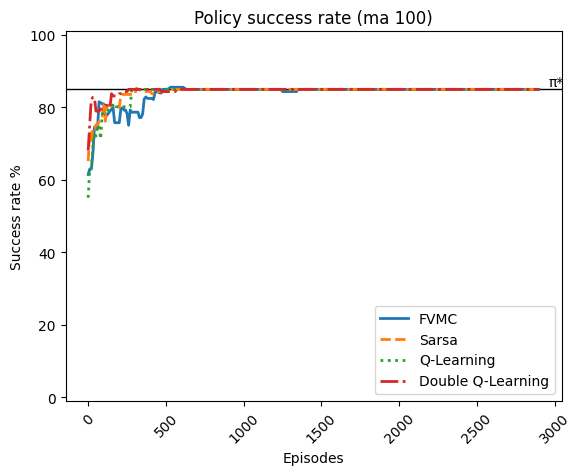

In [71]:
'''policy evaluation comparison:'''
print('Do policy evaluation comparison')
mc_success_rate_ma, mc_mean_return_ma, mc_mean_regret_ma = get_metrics_from_tracks(
    env, gamma, goal_state, optimal_Q, pi_track_mc)
sarsa_success_rate_ma, sarsa_mean_return_ma, sarsa_mean_regret_ma = get_metrics_from_tracks(
    env, gamma, goal_state, optimal_Q, pi_track_sarsa)
ql_success_rate_ma, ql_mean_return_ma, ql_mean_regret_ma = get_metrics_from_tracks(
    env, gamma, goal_state, optimal_Q, pi_track_ql)
dql_success_rate_ma, dql_mean_return_ma, dql_mean_regret_ma = get_metrics_from_tracks(
    env, gamma, goal_state, optimal_Q, pi_track_dql)

# policy success rate
plt.axhline(y=success_rate_op, color='k', linestyle='-', linewidth=1)
plt.text(int(len(mc_success_rate_ma)*1.02), success_rate_op*1.01, 'π*')
plt.plot(mc_success_rate_ma, '-', linewidth=2, label='FVMC')
plt.plot(sarsa_success_rate_ma, '--', linewidth=2, label='Sarsa')
plt.plot(ql_success_rate_ma, ':', linewidth=2, label='Q-Learning')
plt.plot(dql_success_rate_ma, '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=4, ncol=1)

plt.title('Policy success rate (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Success rate %')
plt.ylim(-1, 101)
plt.xticks(rotation=45)
plt.show()


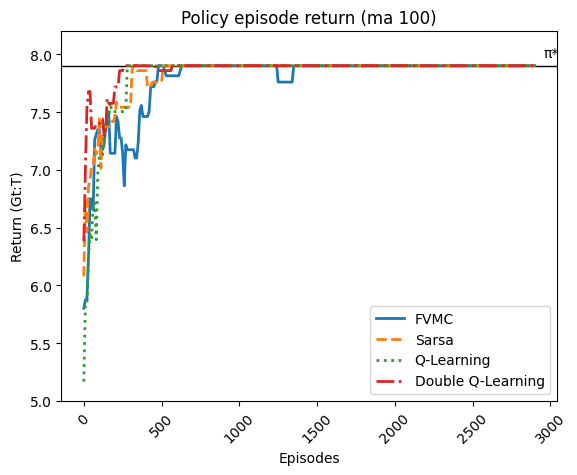

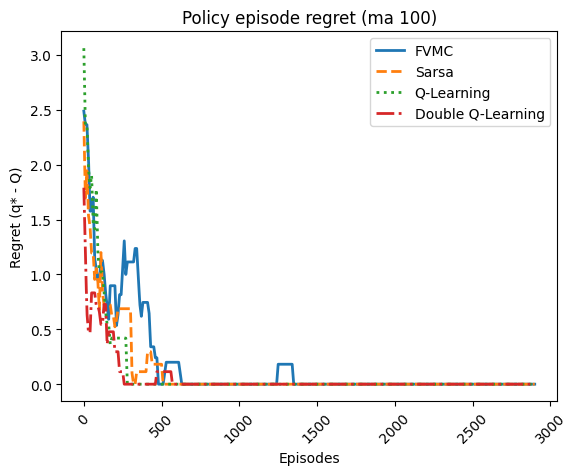

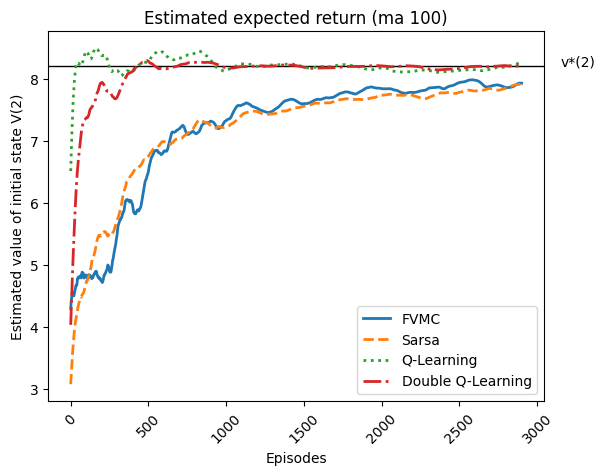

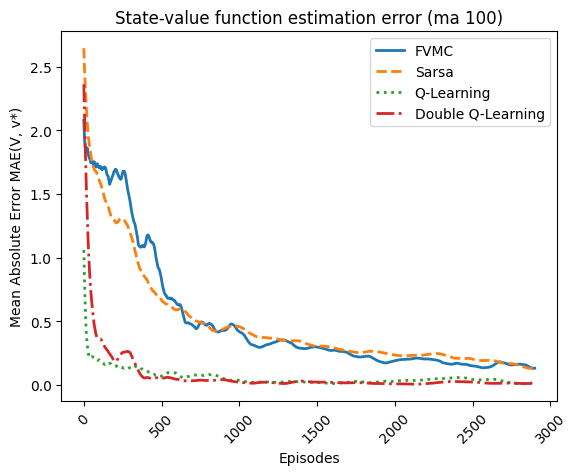

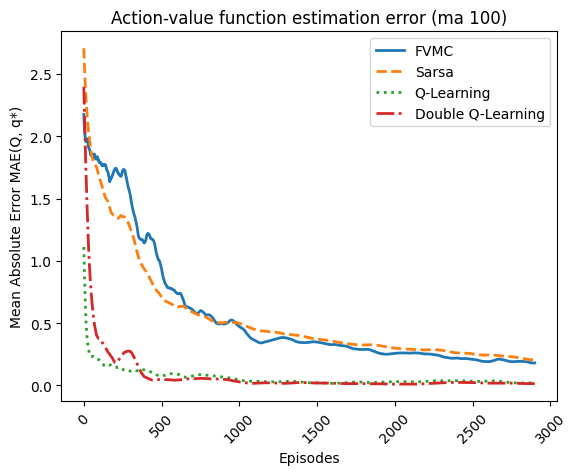

In [72]:
# policy episode return
plt.axhline(y=mean_return_op, color='k', linestyle='-', linewidth=1)
plt.text(int(len(mc_mean_return_ma)*1.02), mean_return_op*1.01, 'π*')

plt.plot(mc_mean_return_ma, '-', linewidth=2, label='FVMC')
plt.plot(sarsa_mean_return_ma, '--', linewidth=2, label='Sarsa')
plt.plot(ql_mean_return_ma, ':', linewidth=2, label='Q-Learning')
plt.plot(dql_mean_return_ma, '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=4, ncol=1)
plt.ylim(5, 8.2)

plt.title('Policy episode return (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Return (Gt:T)')
plt.xticks(rotation=45)
plt.show()

# policy episode regret
plt.plot(mc_mean_regret_ma, '-', linewidth=2, label='FVMC')
plt.plot(sarsa_mean_regret_ma, '--', linewidth=2, label='Sarsa')
plt.plot(ql_mean_regret_ma, ':', linewidth=2, label='Q-Learning')
plt.plot(dql_mean_regret_ma, '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=1, ncol=1)

plt.title('Policy episode regret (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Regret (q* - Q)')
plt.xticks(rotation=45)
plt.show()

# estimated expected return
plt.axhline(y=optimal_V[init_state], color='k', linestyle='-', linewidth=1)
plt.text(int(len(Q_track_mc)*1.05), optimal_V[init_state]+.01, 'v*({})'.format(init_state))

plt.plot(moving_average(np.max(Q_track_mc, axis=2).T[init_state]),
         '-', linewidth=2, label='FVMC')
plt.plot(moving_average(np.max(Q_track_sarsa, axis=2).T[init_state]),
         '--', linewidth=2, label='Sarsa')
plt.plot(moving_average(np.max(Q_track_ql, axis=2).T[init_state]),
         ':', linewidth=2, label='Q-Learning')
plt.plot(moving_average(np.max(Q_track_dql, axis=2).T[init_state]),
         '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=4, ncol=1)

plt.title('Estimated expected return (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Estimated value of initial state V({})'.format(init_state))
plt.xticks(rotation=45)
plt.show()

#state-value function estimation error
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_mc, axis=2) - optimal_V), axis=1)),
         '-', linewidth=2, label='FVMC')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_sarsa, axis=2) - optimal_V), axis=1)),
         '--', linewidth=2, label='Sarsa')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_ql, axis=2) - optimal_V), axis=1)),
         ':', linewidth=2, label='Q-Learning')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_dql, axis=2) - optimal_V), axis=1)),
         '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=1, ncol=1)

plt.title('State-value function estimation error (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error MAE(V, v*)')
plt.xticks(rotation=45)
plt.show()

# action-value function estimation error
plt.plot(moving_average(np.mean(np.abs(Q_track_mc - optimal_Q), axis=(1,2))),
         '-', linewidth=2, label='FVMC')
plt.plot(moving_average(np.mean(np.abs(Q_track_sarsa - optimal_Q), axis=(1,2))),
         '--', linewidth=2, label='Sarsa')
plt.plot(moving_average(np.mean(np.abs(Q_track_ql - optimal_Q), axis=(1,2))),
         ':', linewidth=2, label='Q-Learning')
plt.plot(moving_average(np.mean(np.abs(Q_track_dql - optimal_Q), axis=(1,2))),
         '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=1, ncol=1)

plt.title('Action-value function estimation error (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error MAE(Q, q*)')
plt.xticks(rotation=45)
plt.show()